In [1]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

Creating a particle cloud

In [2]:


def initialize_particles():
    particles = np.random.rand(NUM_PARTICLES,8)
    particles = particles * np.array( (valMed, valMed,valMed,valMed, VEL_RANGE,VEL_RANGE,VEL_RANGE,VEL_RANGE) )
    particles[:,4:8] -= VEL_RANGE/2.0
    #print(particles[:20,:])
    print("-"*20)
    print("Iniciando!!!")
    print("-"*20)
    return particles

Moving particles according to their velocity state

In [3]:
def apply_velocity(particles):
    particles[:,0] += particles[:,4]
    particles[:,1] += particles[:,5]
    particles[:,2] += particles[:,6]
    particles[:,3] += particles[:,7]
    return particles

Measure each particle's quality

In [4]:

def compute_errors(particles,H1,H2,k):
    errors = np.zeros(NUM_PARTICLES)
    for i in range(NUM_PARTICLES):
        w_1 = particles[i,0]
        w_2 = particles[i,1]
        w_3 = particles[i,2]
        w_4 = particles[i,3]
        
        w0 = np.array([ [w_1],[w_2]] )
        w1 = np.array([ [w_3],[w_4]] )
        #X1 = w0[0]*S(x[0,k]) + w0[1]*S(x[1,k])
        #X2 = w1[0]*S(x[0,k]) + w1[1]*S(x[1,k]) + wf*u[k]
       
        X0 = w0.T@H1
        X1 = w1.T@H2 + wf*u[k]
        
        #pixel_colour = frame[ y, x, :]# Referencia k
        errors[i] = np.sum(  (x[0,k] - X0)**2 + (x[1,k] - X1 )**2 )
    return errors

Assign weights to the particles based on their quality of match

In [5]:
def compute_weights(errors):
    weights = np.max(errors) - errors
    #weights [
    #    (particles[:,0] == 0) |
    #    (particles[:,1] == 0) |    
    #    (particles[:,2] == 0) |
    #    (particles[:,3] == 0) 
    #] = 0.0
    
    weights = weights**(weigh_pow)
    
    #print(np.sum(weights))
    
    return weights


Resample particles according to their weights

In [6]:
def resample(particles, weights):
    probabilities = weights / np.sum(weights)
    
    #print("-"*20)
    #print(probabilities)
    #print("-"*20)
    
    index_numbers = np.random.choice(
        NUM_PARTICLES,
        size=NUM_PARTICLES,
        p = probabilities)
    particles = particles[index_numbers,:]
    
    w0 = np.mean(particles[:,0])
    w1 = np.mean(particles[:,1])
    w2 = np.mean(particles[:,2])
    w3 = np.mean(particles[:,3])
        
    w_0 = np.array([ [w0],[w1]] )
    w_1 = np.array([ [w2],[w3]] )
    
    return particles, w_0,w_1

Fuzz the particles

In [7]:
#POS_SIGMA = .1# cambio de valor 
#VEL_SIGMA = .01 # velocidad 

def apply_noise(particles):
    noise = np.concatenate(
    (
        np.random.normal(0.0,POS_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0,POS_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0,POS_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0,POS_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0,VEL_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0,VEL_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0,VEL_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0,VEL_SIGMA, (NUM_PARTICLES,1)),
    ), axis= 1  )
    
    particles += noise
    return particles

In [8]:
#import warnings

In [9]:
#warnings.filterwarnings('ignore')

--------------------
Iniciando!!!
--------------------


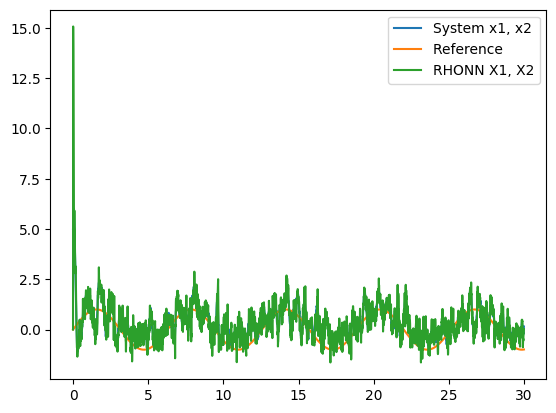

In [76]:
tf = 30 #30 #segundo
T = 0.01
x0 = np.array([5,3])

x = np.zeros( (2,int(tf/T) +1) )
X = np.zeros( (2,int(tf/T) +1) )
u = np.zeros( (int(tf/T) +1) )

x[:,0] = x0
u[0] = 0

np.random.seed(9)

X[:,0] = np.random.normal(0,1,2)
t = np.arange(0,tf,T)

xref = np.sin(t)
tsim = list( range(0, int(tf/T) ) )

#S = lambda x: 1 / (1 + np.exp(-x)) #Función Sigmoide
S = lambda x: max(0,5) #ReLU

wf = 0.01
weigh_pow = 8

POS_SIGMA = .001# cambio de valor 
VEL_SIGMA = .1 # velocidad 

NUM_PARTICLES = 20
VEL_RANGE = 0.5
valMed = 5

particles = initialize_particles()

for k in tsim:
    
    #u[k+1] = -10*x[0,k] -14*x[1,k] - 14*(x[0,k] - xref[k] ) # control law 
    #u[k+1] = -10*X[0,k] -14*x[1,k] - 14*(x[0,k] - xref[k] ) # control law 
    #u[k+1] = -10*X[0,k] -14*x[1,k] - 14*(X[0,k] - xref[k] ) # control law 
    #u[k+1] = -10*X[0,k] -14*X[1,k] - 14*(X[0,k] - xref[k] ) # control law 
    
    u[k+1] = -8*X[0,k] -10*X[1,k] - 10*(X[0,k] - xref[k] ) # control law 
    
    # system's state --------------
    x[0,k+1] = x[0,k] + T *( 3*x[0,k] + 5*x[1,k] + np.exp(-x[0,k])**3 + np.cos(x[0,k]) )  + np.random.normal(0,.1) #np.random.uniform(0,1)/10 
    x[1,k+1] = x[1,k] + T *( 2*x[0,k] + 3*x[1,k] + u[k]) + np.random.normal(0,.1) # system's state
    # system's state off --------------
    
    
    particles = apply_velocity(particles)
    
    H1 = np.array( [ [S(x[0,k])], [S(x[1,k])] ] )
    H2 = np.array( [ [S(x[0,k])], [S(x[1,k])] ] )
    errors = compute_errors(particles,H1,H2,k)
    weights = compute_weights(errors)
    particles,w0,w1 = resample(particles, weights)
    particles = apply_noise(particles)


    X[0,k+1] = w0.T@H1
    
    X[1,k+1] = w1.T@H2 + wf*u[k]
    

tmp = 0

plt.plot(t[tmp:],x[0,tmp:-1], label='System x1, x2')
plt.plot(t[tmp:],xref[tmp:], label='Reference ')
plt.plot(t[tmp:],X[0,tmp:-1], label='RHONN X1, X2')
plt.legend()

In [78]:
errFP = (1/len(x))*np.sum( (x[0,tmp:-1] - xref[tmp:])**2 )
errFP 

773.5166068670546

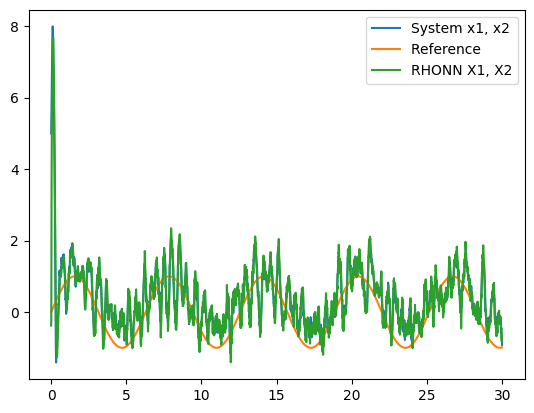

In [79]:
tf = 30 #segundo
T = 0.01
x0 = np.array([5,3])

x = np.zeros( (2,int(tf/T) +1) )
X = np.zeros( (2,int(tf/T) +1) )
u = np.zeros( (int(tf/T) +1) )

x[:,0] = x0
u[0] = 0

np.random.seed(9)
w0 = np.random.normal(0,1,(2,1))
w1 = np.random.normal(0,1,(2,1))

X[:,0] = np.random.normal(0,1,2)

t = np.arange(0,tf,T)
xref = np.sin(t)

tsim = list( range(0, int(tf/T) ) )

S = lambda x: 1 / (1 + np.exp(-0.5*x))

P = [10E-10 * np.eye(2), 10E-10 * np.eye(2)] 
Q = [10E-6 * np.eye(2), 10E-6 * np.eye(2)]
R = [10E-7,10E-10]
eta = [0.5,1]

wf = 1

def EKF(H,w,k,edo=0):
    global x,X
    e = x[edo,k] - X[edo,k] # error x0 - X0    
    #H = np.array( [ [S(x[0,k])], [S(x[1,k])] ] )  # partial derivative of one of nn state with respect to one nn weight
    M = np.linalg.pinv(R[edo] + H.T@P[edo]@H) # 
    K = P[edo] @ H @ M # Kalman gain
    P[edo] = P[edo] - K@H.T@P[edo] + Q[edo]
    w = w + eta[edo]*K*e
        
    return w
    


for k in tsim:
    #u[k+1] = -10*x[0,k] -14*x[1,k] - 14*(x[0,k] - xref[k] ) # control law 
    #u[k+1] = -10*X[0,k] -14*x[1,k] - 14*(x[0,k] - xref[k] ) # control law 
    u[k+1] = -10*X[0,k] -14*X[1,k] - 14*(X[0,k] - xref[k] ) # control law 
    
    x[0,k+1] = x[0,k] + T *( 3*x[0,k] + 5*x[1,k] + np.exp(-x[0,k])**3 + np.cos(x[0,k]) )  + np.random.normal(0,.1)#+np.random.uniform(0,1)/10 # system's state
    x[1,k+1] = x[1,k] + T *( 2*x[0,k] + 3*x[1,k] + u[k]) + np.random.normal(0,.1) # system's state

    H = np.array( [ [S(x[0,k])], [S(x[1,k])] ] )
    w0=EKF(H,w0,k,0)   
    #X[0,k+1] = w0[0]*S(x[0,k]) + w0[1]*S(x[1,k])
    X[0,k+1] = w0.T@H

    #H = np.array( [ [S(x[0,k])], [S(x[1,k])*S(x[0,k])] ] )
    #H = np.array( [ [S(x[0,k])], [S(x[1,k])**3] ] )
    H = np.array( [ [S(x[0,k])], [S(x[1,k])] ] )
    w1=EKF(H,w1,k,1)
    #X[1,k+1] = w1[0]*S(x[0,k]) + w1[1]*S(x[1,k]) + wf*u[k]
    X[1,k+1] = w1.T@H
    
#tmp= int(.9/T)
#tmp= int(2/T)
tmp = 0

plt.plot(t[tmp:],x[0,tmp:-1], label='System x1, x2')
plt.plot(t[tmp:],xref[tmp:], label='Reference ')
plt.plot(t[tmp:],X[0,tmp:-1], label='RHONN X1, X2')
plt.legend()

In [80]:
errEKF = (1/len(x))*np.sum( (x[0,tmp:-1] - xref[tmp:])**2 )
errEKF 

1064.5866889548197

In [81]:
errFP

773.5166068670546